In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition)
from pyabc.populationstrategy import AdaptivePopulationSize
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tempfile
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [2]:
def simulate(**pars):
    """Wrapper to simulate the myokit model.
    
    Simulates in a subprocess running python2 by passing
    parameters as arguments to (another) wrapper script.
    
    Args:
        pars: Parameters as kwargs.
        
    Returns:
        Dataframe with simulated output or empty if
        the simulation failed.
    """
    myokit_python = ("/Users/charles/miniconda3/envs" +
                     "/ion_channel_ABC/bin/python")
    script = "run_channel.py"
    args = [myokit_python, script]
    for p in pars:
        try:
            args.append("-" + str(p))
            args.append(str(pars[p]))
        except:
            print("Error: " +
                  "args is " + str(args))
    re = subprocess.run(args, stdout=subprocess.PIPE)
    if len(re.stdout) > 0:
        d = pd.read_table(BytesIO(re.stdout),
                          delim_whitespace=True,
                          header=0, index_col=0)
    else:
        d = pd.DataFrame({})
    return d

In [3]:
myokit_python = ("/Users/charles/miniconda3/envs" +
                 "/ion_channel_ABC/bin/python")
args = [myokit_python, "get_measurements.py"]
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=0)
print(measurements)

    exp    x          y
0     0 -150 -42.400000
1     0 -140 -37.624943
2     0 -130 -34.941514
3     0 -120 -31.601044
4     0 -110 -28.020617
5     0 -100 -24.859378
6     0  -90 -20.024437
7     0  -80 -16.922767
8     0  -70 -12.146974
9     0  -60  -8.686631
10    0  -50  -4.927499
11    0  -40  -2.961311
12    0  -30  -1.414205
13    0  -20   0.253088
14    0  -10   1.322383
15    0    0   2.152038
16    0   10   2.623545
17    0   20   2.676390
18    0   30   2.071667


In [4]:
limits = dict(g_K1=(0, 0.2),
              k_1=(-500, 500),
              k_2=(0, 50),
              k_3=(0, 1),
              k_4=(0, 0.1))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})
print(prior)

<Distribution 'g_K1', 'k_1', 'k_2', 'k_3', 'k_4'>


In [5]:
def distance(sim, obs):
    if sim.empty:
        return float("inf")
    dist = 0
    for i in obs.exp.unique():
        try:
            err = np.sum(np.square(obs[obs.exp == i].y - sim[sim.exp == i].y))
        except:
            return float("inf")
        err = pow(err / len(obs[obs.exp == i].y), 0.5)
        err /= np.ptp(obs[obs.exp == i].y)
        dist += err
    return dist

In [6]:
def simulate_pyabc(parameter):
    res = simulate(**parameter)
    return res

In [7]:
abc = ABCSMC(simulate_pyabc, prior, distance,
             population_size=AdaptivePopulationSize(100, 0.2))
abc_id = abc.new(db_path, measurements)

INFO:Epsilon:initial epsilon is 0.2722250346616456
INFO:History:Start <ABCSMC(id=18, start_time=2018-04-22 13:55:38.531257, end_time=None)>


In [ ]:
history = abc.run(max_nr_populations=10, minimum_epsilon=0.01)

INFO:ABC:t:0 eps:0.2722250346616456
INFO:ABC:t:1 eps:0.1656214935706286
INFO:Adaptation:Change nr particles 100 -> 1764


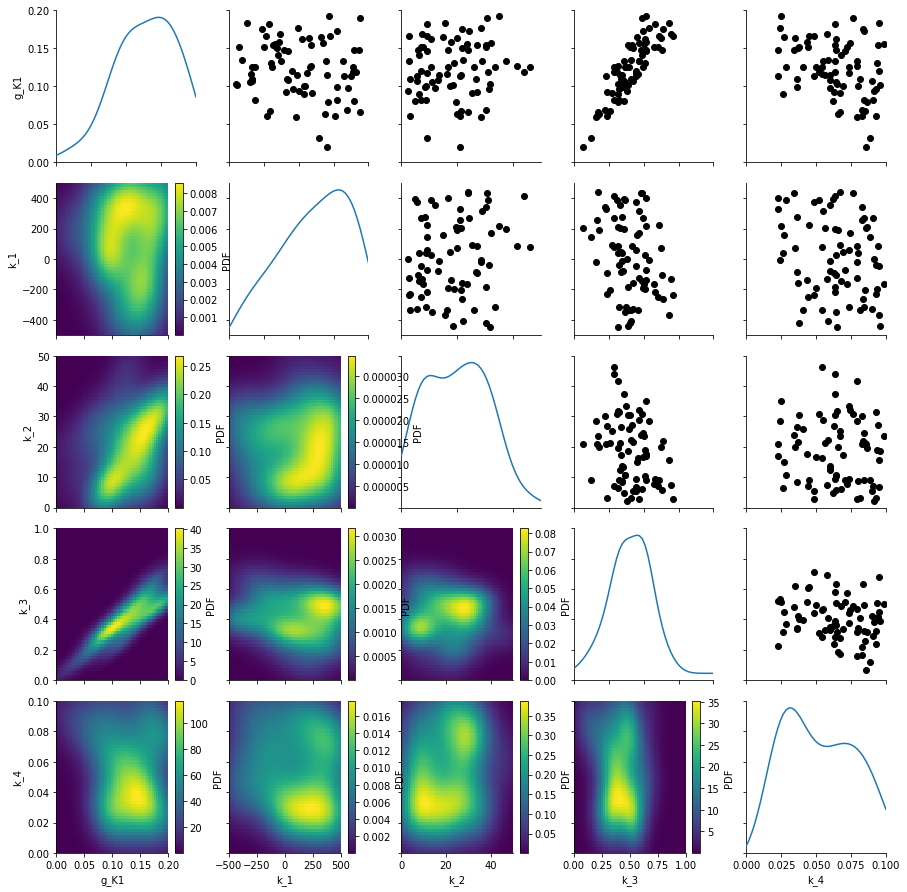

In [13]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [16]:
abc_continued = ABCSMC(simulate_pyabc, prior, distance,
                       population_size=AdaptivePopulationSize(20, 0.5))
abc_continued.load(db_path, abc_id)
abc_continued.run(max_nr_populations=10, minimum_epsilon=.01)

/Users/charles/miniconda3/envs/pyabc/lib/python3.6/site-packages/pyabc/storage/numpy_bytes_storage.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if type_(arr) == arr:
INFO:ABC:t:3 eps:0.05884799783193449
INFO:Adaptation:Change nr particles 20 -> 50
Process Process-18:
Process Process-20:
Process Process-19:
Process Process-17:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/charles/miniconda3/envs/pyabc/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/charles/miniconda3/envs/pyabc/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/charles/miniconda3/envs/pyabc/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/charles/miniconda3/envs

ProcessError: At least one worker is dead.